Install the legacy NASA CDF C library

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# Configure Matplotlib

Choose a matplotlib style sheet to match your browser theme (dark or light)

Increase the figure size to match the notebook width.

Set the graph colour variables.

In [2]:
#style_sheet = 'dark_background' # dark theme
style_sheet = 'default'         # light theme
plt.style.use(style_sheet)

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

dsc_colour = 'green'
wnd_colour = 'magenta'
anl_colour = 'red'

# Time Conversion functions

Let's define some helper functions to convert some time formats into human readable time

In [ ]:
def time_from_seconds(seconds):
  seconds = seconds % (24 * 3600)
  hour = seconds // 3600
  seconds %= 3600
  minutes = seconds // 60
  seconds %= 60

  return "%d:%02d:%02d" % (hour, minutes, seconds)

def time_from_doy(doy):
  part, whole = np.modf(doy)
  seconds = part * 86400

  return time_from_seconds(seconds)

In [ ]:
print("3600 seconds: %s" %(time_from_seconds(3600)))
print("0.04167 days: %s" %(time_from_doy(0.04167)))

3600 seconds: 1:00:00
0.04167 days: 1:00:00


# DSCOVR data

The DSCOVR  data is provided in the challenge resources. We will use 2022 data for our training and validation sets and 2023 data for a test set.
In machine learning we call the data we have, *X*. and teach (train) a model to learn a mapping of *X* to *Y* where *Y* is what we want the model to output.

Before we move on to *Y* let's have a look at *X* ...

First we need to download the data that we need from the UH/IfA data transfer node [spaceapps repo](https://dtn-itc.ifa.hawaii.edu/spaceapps/DSCOVR.tgz)

In [6]:
!wget https://opensource.gsfc.nasa.gov/spaceappschallenge/dsc_fc_summed_spectra_2022_v01.zip
!wget https://opensource.gsfc.nasa.gov/spaceappschallenge/dsc_fc_summed_spectra_2023_v01.zip
!mkdir -p ./data/dscovr
!(cd ./data/dscovr;unzip ../../dsc_fc_summed_spectra_2022_v01.zip; unzip ../../dsc_fc_summed_spectra_2023_v01.zip)


--2023-10-08 07:14:31--  https://opensource.gsfc.nasa.gov/spaceappschallenge/dsc_fc_summed_spectra_2022_v01.zip
Resolving opensource.gsfc.nasa.gov (opensource.gsfc.nasa.gov)... 129.164.181.182, 2001:4d0:2310:153::6
Connecting to opensource.gsfc.nasa.gov (opensource.gsfc.nasa.gov)|129.164.181.182|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57868570 (55M) [application/zip]
Saving to: ‘dsc_fc_summed_spectra_2022_v01.zip.1’

dsc_fc_summed_spect 100%[===================>]  55.19M  70.5MB/s    in 0.8s    

2023-10-08 07:14:32 (70.5 MB/s) - ‘dsc_fc_summed_spectra_2022_v01.zip.1’ saved [57868570/57868570]

--2023-10-08 07:14:32--  https://opensource.gsfc.nasa.gov/spaceappschallenge/dsc_fc_summed_spectra_2023_v01.zip
Resolving opensource.gsfc.nasa.gov (opensource.gsfc.nasa.gov)... 129.164.181.182, 2001:4d0:2310:153::6
Connecting to opensource.gsfc.nasa.gov (opensource.gsfc.nasa.gov)|129.164.181.182|:443... connected.
HTTP request sent, awaiting response... 200 OK
L

In [7]:
!ls ./data/dscovr

dsc_fc_summed_spectra_2022_v01.csv  dsc_fc_summed_spectra_2023_v01.csv


# DSCOVR data
The DSCOVR data we need for training our model is now stored locally in ./data.
Let's take a look at the data we just downloaded.

In [8]:
dscovr_df = pd.read_csv("./data/dscovr/dsc_fc_summed_spectra_2022_v01.csv", delimiter = ',', parse_dates=[0], infer_datetime_format=True, na_values='0', header = None)

In [9]:
dscovr_df.head()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,2022-01-01 00:00:00,-6.17170,1.124830,-4.90228,38.0314,0.231726,46.0427,44.9743,55.9143,43.7069,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-01 00:01:00,-6.28883,1.233130,-4.79001,38.3868,0.231726,45.5257,46.2587,55.1428,43.2768,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-01-01 00:02:00,-6.11811,0.871923,-5.12830,37.5636,0.231726,45.1955,46.8222,55.7484,42.7894,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-01-01 00:03:00,-6.28704,1.249870,-4.76640,38.1094,0.242084,46.7083,47.1713,53.5380,42.1558,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-01-01 00:04:00,-6.42125,1.171560,-4.53230,37.5893,0.231726,47.4888,45.3234,54.5404,44.2773,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
dscovr_df.describe()

,1,2,3,4,5,6,7,8,9,10,...,44,45,46,47,48,49,50,51,52,53
count,524450.000000,524450.000000,524450.000000,511816.000000,511811.000000,511809.000000,511809.000000,511815.000000,511815.000000,511814.000000,...,20115.000000,11191.000000,8416.000000,3971.000000,3859.000000,213.000000,139.000000,44.000000,40.000000,35.000000
mean,0.098939,-0.219225,0.060599,58.218162,9.514369,63.246343,56.563212,74.062121,65.428809,94.261894,...,384.711976,332.966637,388.589832,326.915073,294.150454,390.130451,384.123885,376.326977,403.068593,367.789749
std,3.943064,4.535931,3.667523,38.506281,17.031107,44.696797,45.047853,60.528255,82.509457,114.361904,...,40.774888,48.215582,38.280578,57.801942,85.771695,52.754546,51.583450,69.893480,124.156716,143.007012
min,-16.712300,-26.376500,-23.060000,0.231726,0.231726,0.231726,0.231726,0.231726,0.231726,0.231726,...,214.319000,188.544000,211.826000,205.870000,108.950000,202.247000,112.290000,187.778000,0.231726,89.996200
25%,-3.000140,-3.305092,-1.967988,28.843000,0.231726,32.352500,27.916000,37.301550,25.640400,36.973425,...,365.230000,302.532500,367.203750,274.956000,211.853000,359.223000,352.946500,354.073000,366.691750,241.622000
50%,0.212469,-0.288369,0.034746,51.989300,0.386813,55.570600,46.977600,61.355300,45.470200,68.838050,...,383.495000,326.713000,393.807500,323.581000,309.980000,389.128000,395.347000,383.129500,427.067000,403.663000
75%,3.164427,3.017987,2.039108,84.737900,15.812800,90.033900,80.592700,100.403000,84.142500,114.472000,...,404.069000,363.782500,409.080750,377.611000,367.034500,416.967000,410.484000,411.971250,471.866000,449.118500
max,19.725300,22.834700,27.905900,415.389000,385.676000,493.748000,746.807000,1136.670000,1562.550000,1804.560000,...,662.013000,735.132000,772.122000,521.745000,541.136000,637.731000,568.053000,528.470000,655.892000,646.111000


Take a look at the data statistics. There are not always the same number of rows for each column so we need to watch for missing data. The index is the timestamp for each row. The values in columns 1-3 are the magnetic field vector. The remaining columns contain the solar wind values.

# Daily Space Weather Kp indices

Next let's download the rest of our training data. This will be the *Y* that we want to predict. It is an integer value between 0 and 9 that describes the strength of the predicted geomagnetic field and relates to the likelihood of a geomagnetic storm.

We have staged the data for 2022 and 2023 that we obtained from the [NOAA web site](ftp:/ftp.ngdc.noaa.gov/STP/swpc_products/daily_reports/space_weather_indices) on our UH/IfA data transfer node [spaceapps data repo](http://dtn-itc.ifa.hawaii.edu/spaceapps/SWID.tgz)

In [19]:
!wget http://dtn-itc.ifa.hawaii.edu/spaceapps/SWID.tgz
!tar xzvf SWID.tgz


--2023-10-08 07:26:32--  http://dtn-itc.ifa.hawaii.edu/spaceapps/SWID.tgz
Resolving dtn-itc.ifa.hawaii.edu (dtn-itc.ifa.hawaii.edu)... 128.171.123.136
Connecting to dtn-itc.ifa.hawaii.edu (dtn-itc.ifa.hawaii.edu)|128.171.123.136|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 127530 (125K) [application/x-gzip]
Saving to: ‘SWID.tgz.1’

SWID.tgz.1          100%[===================>] 124.54K   127KB/s    in 1.0s    

2023-10-08 07:26:34 (127 KB/s) - ‘SWID.tgz.1’ saved [127530/127530]

./data/swpc/
./data/swpc/2022/
./data/swpc/2022/04/
./data/swpc/2022/04/20220401dayind.txt
./data/swpc/2022/04/20220402dayind.txt
./data/swpc/2022/04/20220403dayind.txt
./data/swpc/2022/04/20220404dayind.txt
./data/swpc/2022/04/20220405dayind.txt
./data/swpc/2022/04/20220406dayind.txt
./data/swpc/2022/04/20220407dayind.txt
./data/swpc/2022/04/20220408dayind.txt
./data/swpc/2022/04/20220409dayind.txt
./data/swpc/2022/04/20220410dayind.txt
./data/swpc/2022/04/20220411dayind.txt
./data/

In [22]:
!tail -9 ./data/swpc/2023/10/20231007dayind.txt

# ----- Fredericksburg -----           --------- Boulder ---------
# A        K-indices                   A        K-indices
#     03-06-09-12-15-18-21-24              03-06-09-12-15-18-21-24
 -1    1  2 -1 -1 -1 -1 -1 -1          4    1  2  1  0  1  1  1  2 
#        High Latitude                                  Estimated
# --------- College ---------      -------------------- Planetary --------------------
# A       K-indices                A                    K-indices
#     03-06-09-12-15-18-21-24            03  - 06  - 09  - 12  - 15  - 18  - 21  - 24
  2    1  1  1  0  0  0  1  0      5    1.33  2.00  1.33  0.67  0.33  0.33  1.67  1.67 


We will need to parse each of these files, grabbing the last line and the last 8 floating point values which will be the daily planetary K-indices that we want to predict.

In [23]:
!tail -1 ./data/swpc/2023/10/20231007dayind.txt | awk '{print $11, $12, $13, $14, $15, $16, $17, $18}'

1.33 2.00 1.33 0.67 0.33 0.33 1.67 1.67


We provide a useful shell script to do this for every file for 2022 and save the output in a single csv file. One file for 2022 and one file for 2023.

In [ ]:
!bash ./parse_kp_indices.sh

This is the global metadata record of the file:

ADID_ref: NSSD0141 [CDF_CHAR]
Attitude_file: wi_at_pre_20220513_v02.cdf [CDF_CHAR]
               wi_at_pre_20220514_v02.cdf [CDF_CHAR]
               wi_at_pre_20220515_v02.cdf [CDF_CHAR]
Data_type: H2>High-resolution Definitive Data [CDF_CHAR]
Data_version: 04 [CDF_CHAR]
Descriptor: MFI>Magnetic Fields Investigation [CDF_CHAR]
Discipline: Space Physics>Heliospheric Science [CDF_CHAR]
HKlvl_0_file: wi_lz_scr_20220513_v01.dat [CDF_CHAR]
              wi_lz_scr_20220514_v01.dat [CDF_CHAR]
              wi_lz_scr_20220515_v01.dat [CDF_CHAR]
Instrument_type: Magnetic Fields (space) [CDF_CHAR]
Level_0_file: wi_lz_mfi_20220513_v01.dat [CDF_CHAR]
              wi_lz_mfi_20220514_v01.dat [CDF_CHAR]
              wi_lz_mfi_20220515_v01.dat [CDF_CHAR]
Logical_file_id: wi_h2_mfi_00000000_v00 [CDF_CHAR]
Logical_source: wi_h2_mfi [CDF_CHAR]
Logical_source_description: Wind Magnetic Fields Investigation, High-resolution Definitive Data [CDF_CHAR]
MOD

# DSCOVR magnetic field data

The final piece of data that we need is the DSCOVR magnetic field observation data.
As mentioned earlier, we will combine this with the same data observed by WIND.
We will leave the details of how we do this until later. For now, let's inspect the WIND data

In [ ]:
DSC_MFI_DIR = 'data/raw/DSCVR/mfi/2022'
wnd_mfi_sample = 'wi_h2_mfi_20220101_v04.cdf'

!ls $DSC_MFI_DIR | wc -l
!ls -l $DSC_MFI_DIR/dscovr_h0_mag_20220514_v01.cdf
!file $DSC_MFI_DIR/dscovr_h0_mag_20220514_v01.cdf

260
-rw-rw-r-- 1 1000 1000 7283670 Jul 11  2022 data/raw/DSCVR/mfi/2022/dscovr_h0_mag_20220514_v01.cdf
data/raw/DSCVR/mfi/2022/dscovr_h0_mag_20220514_v01.cdf: Common Data Format (Version 2.6 or 2.7) data


In [ ]:
xdsc_filename = os.path.join(DSC_MFI_DIR,'dscovr_h0_mag_20220514_v01.cdf')
cdf_xdsc = pycdf.CDF(xdsc_filename)

In [ ]:
print('These are the variables within this file:\n')
print(cdf_xdsc)

These are the variables within this file:

B1F1: CDF_REAL4 [86400]
B1GSE: CDF_REAL4 [86400, 3]
B1RTN: CDF_REAL4 [86400, 3]
B1SDF1: CDF_REAL4 [86400]
B1SDGSE: CDF_REAL4 [86400, 3]
B1SDRTN: CDF_REAL4 [86400, 3]
Epoch1: CDF_EPOCH [86400]
FLAG1: CDF_INT2 [86400]
NUM1_PTS: CDF_INT4 [86400]
RANGE1: CDF_INT2 [86400]
SENS: CDF_REAL4 [3, 8] NRV
Time1_PB5: CDF_INT4 [86400, 3]
ZERO: CDF_REAL4 [3, 8] NRV
format_time: CDF_CHAR*2 [3] NRV
label_bgse: CDF_CHAR*8 [3] NRV
label_brtn: CDF_CHAR*8 [3] NRV
label_bsdgse: CDF_CHAR*14 [3] NRV
label_bsdrtn: CDF_CHAR*14 [3] NRV
label_time: CDF_CHAR*27 [3] NRV
unit_time: CDF_CHAR*4 [3] NRV


In [ ]:
print('This is the global metadata record of the file:\n')
print(cdf_xdsc.attrs)

This is the global metadata record of the file:

Data_type: H0>1-sec Definitive Data [CDF_CHAR]
Data_version: 1 [CDF_CHAR]
Descriptor: MAG>Fluxgate Magnetometer [CDF_CHAR]
Discipline: Space Physics>Heliospheric Science [CDF_CHAR]
File_naming_convention: source_datatype_descriptor_yyyyMMdd [CDF_CHAR]
Instrument_type: Magnetic Fields (space) [CDF_CHAR]
Logical_file_id: dscovr_h0_mag_20220514_v01 [CDF_CHAR]
Logical_source: dscovr_h0_mag [CDF_CHAR]
Logical_source_description: DSCOVR Fluxgate Magnetometer 1-sec Definitive Data [CDF_CHAR]
MODS: 12/01/2016 Initial release [CDF_CHAR]
Mission_group: DSCOVR [CDF_CHAR]
PI_affiliation: UMBC, NASA/GSFC [CDF_CHAR]
PI_name: A. Koval [CDF_CHAR]
Processing_date: Fri Jul  8 22:03:11 2022 UTC [CDF_CHAR]
Project: DSCOVR>Deep Space Climate Observatory [CDF_CHAR]
Software_version: V01.00 [CDF_CHAR]
Source_name: DSCOVR>Deep Space Climate Observatory [CDF_CHAR]
TEXT: DSCOVR Fluxgate Magnetometer 1-sec Definitive Data                               [CDF_CHAR]
T

In [ ]:
print('This is the global metadata record of the file:\n')
print(cdf_xdsc['B1GSE'].attrs)

This is the global metadata record of the file:

CATDESC: Magnetic field vector in GSE cartesian coordinates (1 sec) [CDF_CHAR]
DEPEND_0: Epoch1 [CDF_CHAR]
DISPLAY_TYPE: time_series [CDF_CHAR]
FIELDNAM: Magnetic field vector in GSE cartesian coordinates (1 sec) [CDF_CHAR]
FILLVAL: -1e+31 [CDF_FLOAT]
FORMAT: E13.6 [CDF_CHAR]
LABL_PTR_1: label_bgse [CDF_CHAR]
MONOTON: FALSE [CDF_CHAR]
SCALEMAX: [14.442259 18.562836 16.361279] [CDF_FLOAT]
SCALEMIN: [-15.509157 -14.402063 -11.871084] [CDF_FLOAT]
SCALETYP: LINEAR [CDF_CHAR]
TIME_RES: 1 sec [CDF_CHAR]
UNITS: nT [CDF_CHAR]
VALIDMAX: [65534. 65534. 65534.] [CDF_FLOAT]
VALIDMIN: [-65534. -65534. -65534.] [CDF_FLOAT]
VAR_TYPE: data [CDF_CHAR]


In [ ]:
dsc_B = cdf_xdsc['B1GSE']
wnd_B = cdf_xwnd['BGSE']

Let's plot 1 hour of data from WIND and DSCOVR for the same time.
Remember that these two satellites are in different places in space for a given time.
So we don't expect these plots to be correlated.

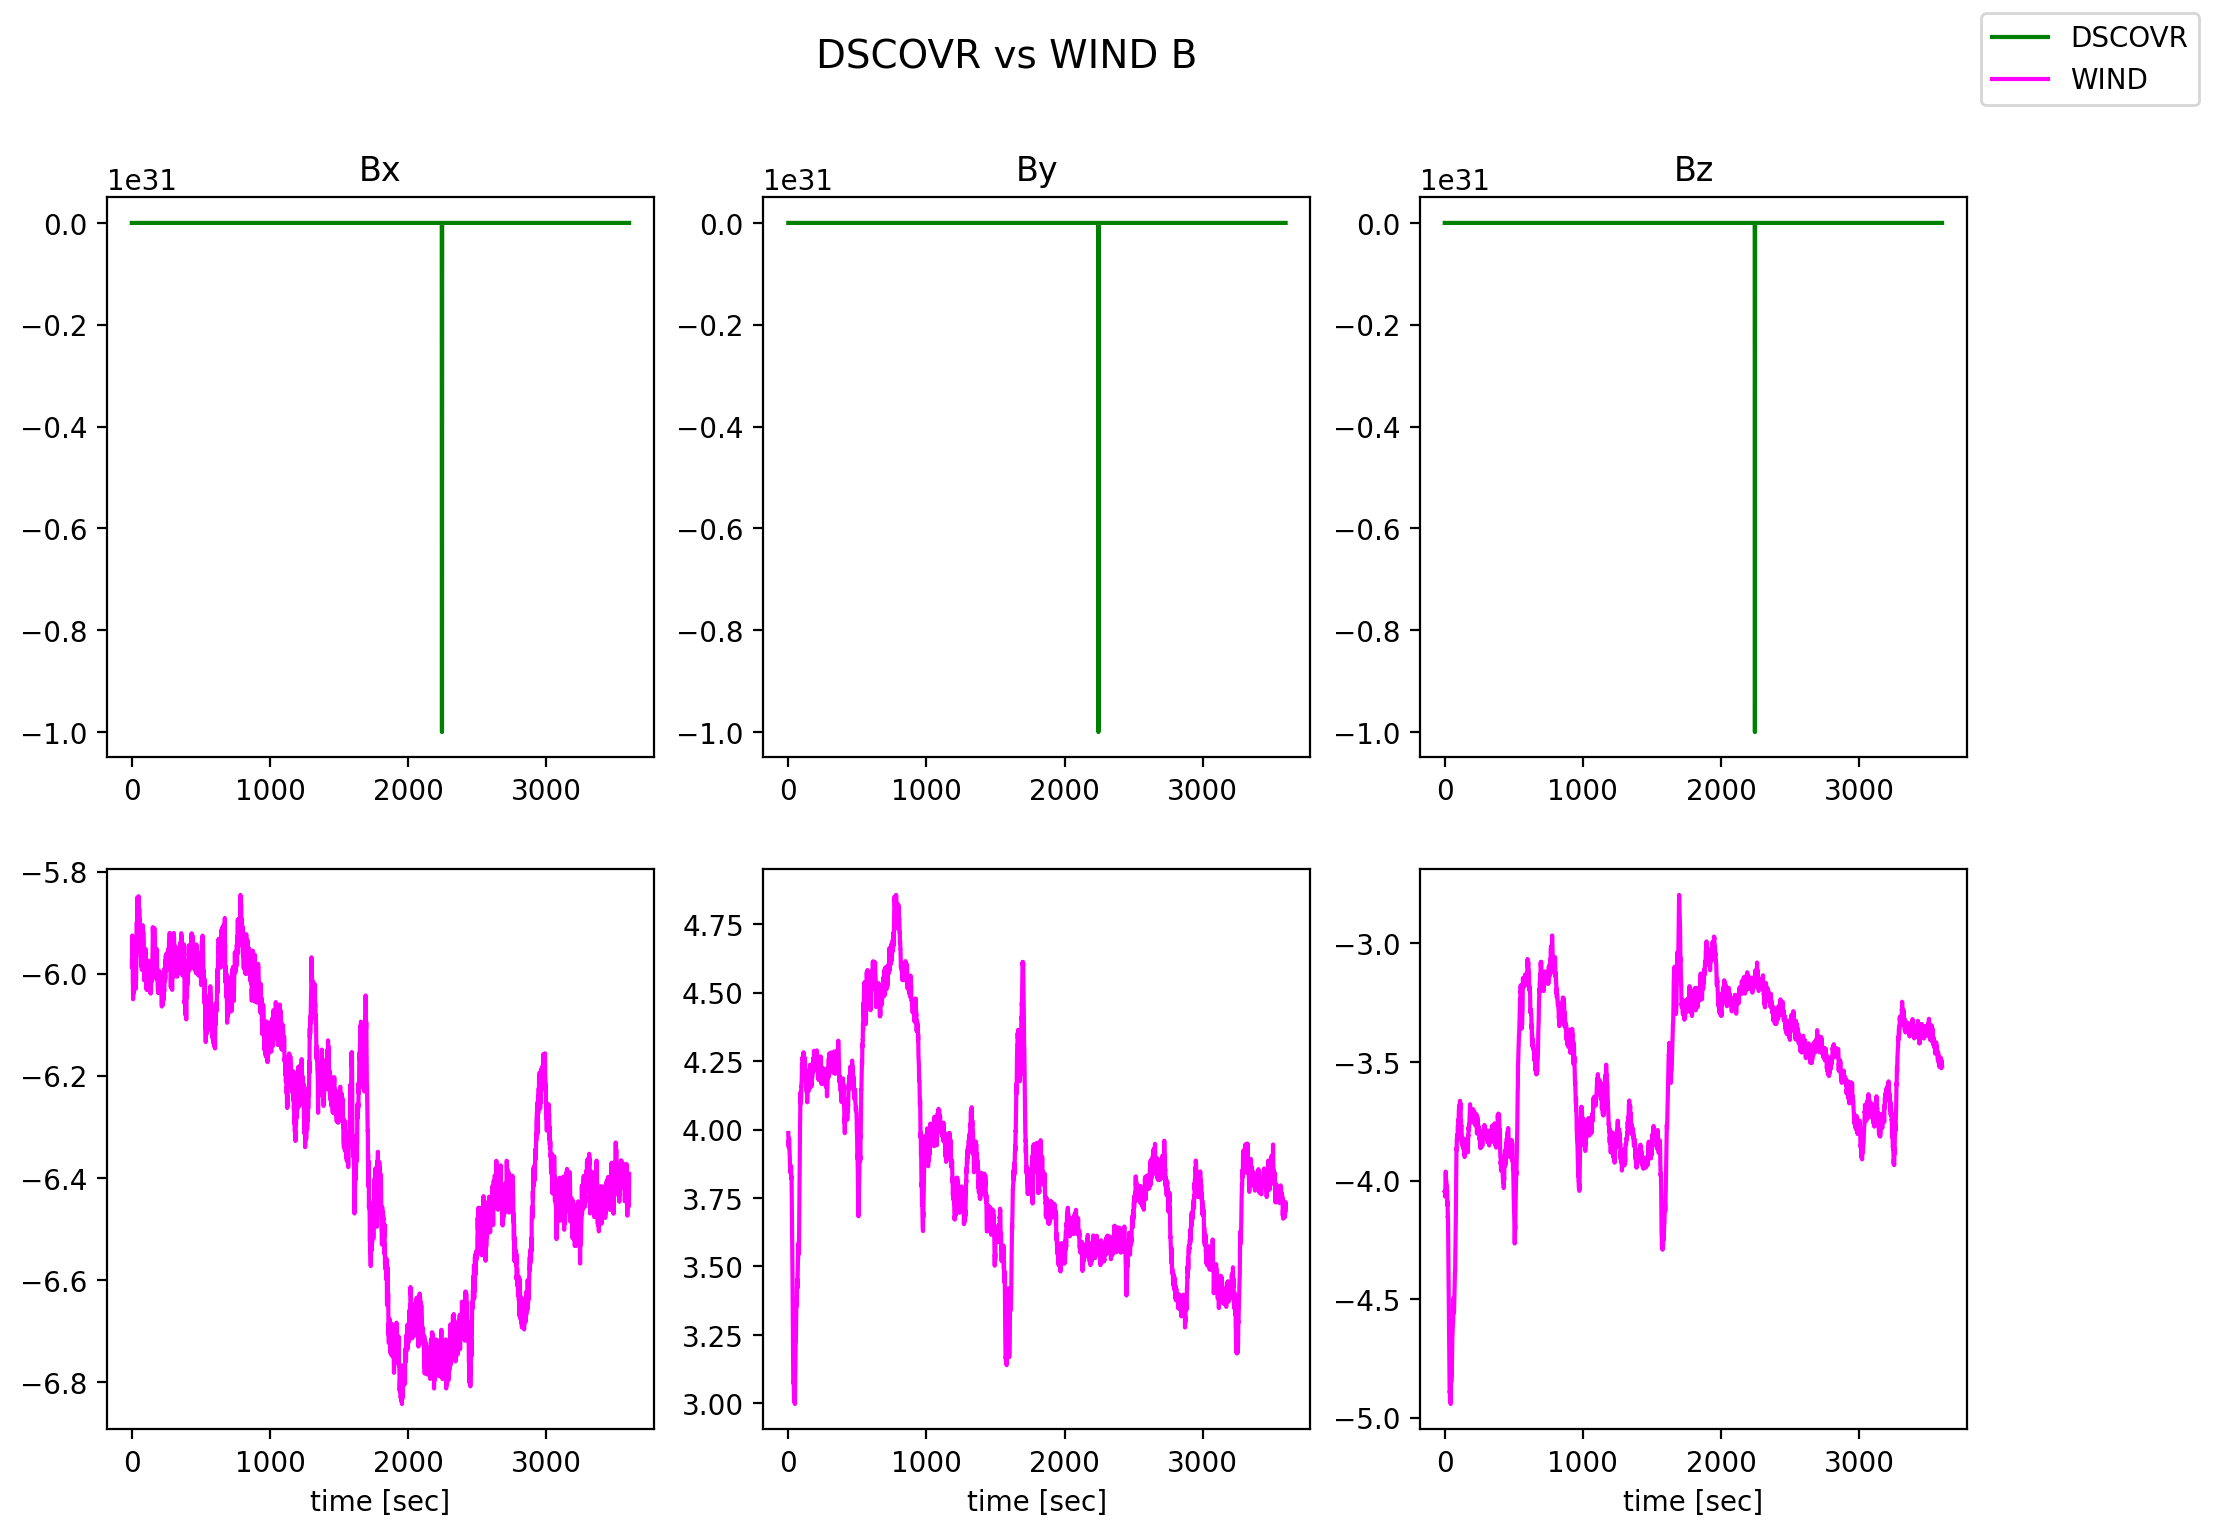

In [ ]:
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
#plt.rcParams['figure.figsize'] = [12, 8]
#plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower

fig, axs = plt.subplots(2, 3)
title = 'DSCOVR vs WIND B'
fig.suptitle(title, fontsize=14)
start = 0
stop = 3600
time_axis = np.linspace(start, stop, num=stop-start, endpoint=False)

d_bx, = axs[0,0].plot(time_axis, dsc_B[start:stop,0], color=dsc_colour, label='Bx')
d_by, = axs[0,1].plot(time_axis, dsc_B[start:stop,1], color=dsc_colour, label='By')
d_bz, = axs[0,2].plot(time_axis, dsc_B[start:stop,2], color=dsc_colour, label='Bz')
axs[0, 0].set(title='Bx')
axs[0, 1].set(title='By')
axs[0, 2].set(title='Bz')
#axs[0, 0].set(xlim=(-500,1500))
axs[1, 0].set(xlabel='time [sec]')
axs[1, 1].set(xlabel='time [sec]')
axs[1, 2].set(xlabel='time [sec]')

w_bx, = axs[1,0].plot(time_axis, wnd_B[start:stop,0], color=wnd_colour, label='Bx')
w_by, = axs[1,1].plot(time_axis, wnd_B[start:stop,1], color=wnd_colour, label='By')
w_bz, = axs[1,2].plot(time_axis, wnd_B[start:stop,2], color=wnd_colour, label='Bz')

fig.legend([d_bx, w_bx], ['DSCOVR', 'WIND'], loc='upper right')

Yikes! What is going on with the DSCOVR data?
There are some bad data points getting plotted that are skewing the range of the plot.

We will build a filter later so for now let's restrict the plot range to a reasonable scale.

Also, some values are negative and others are positive. We need to orient the axes with the minimum values at the bottom.

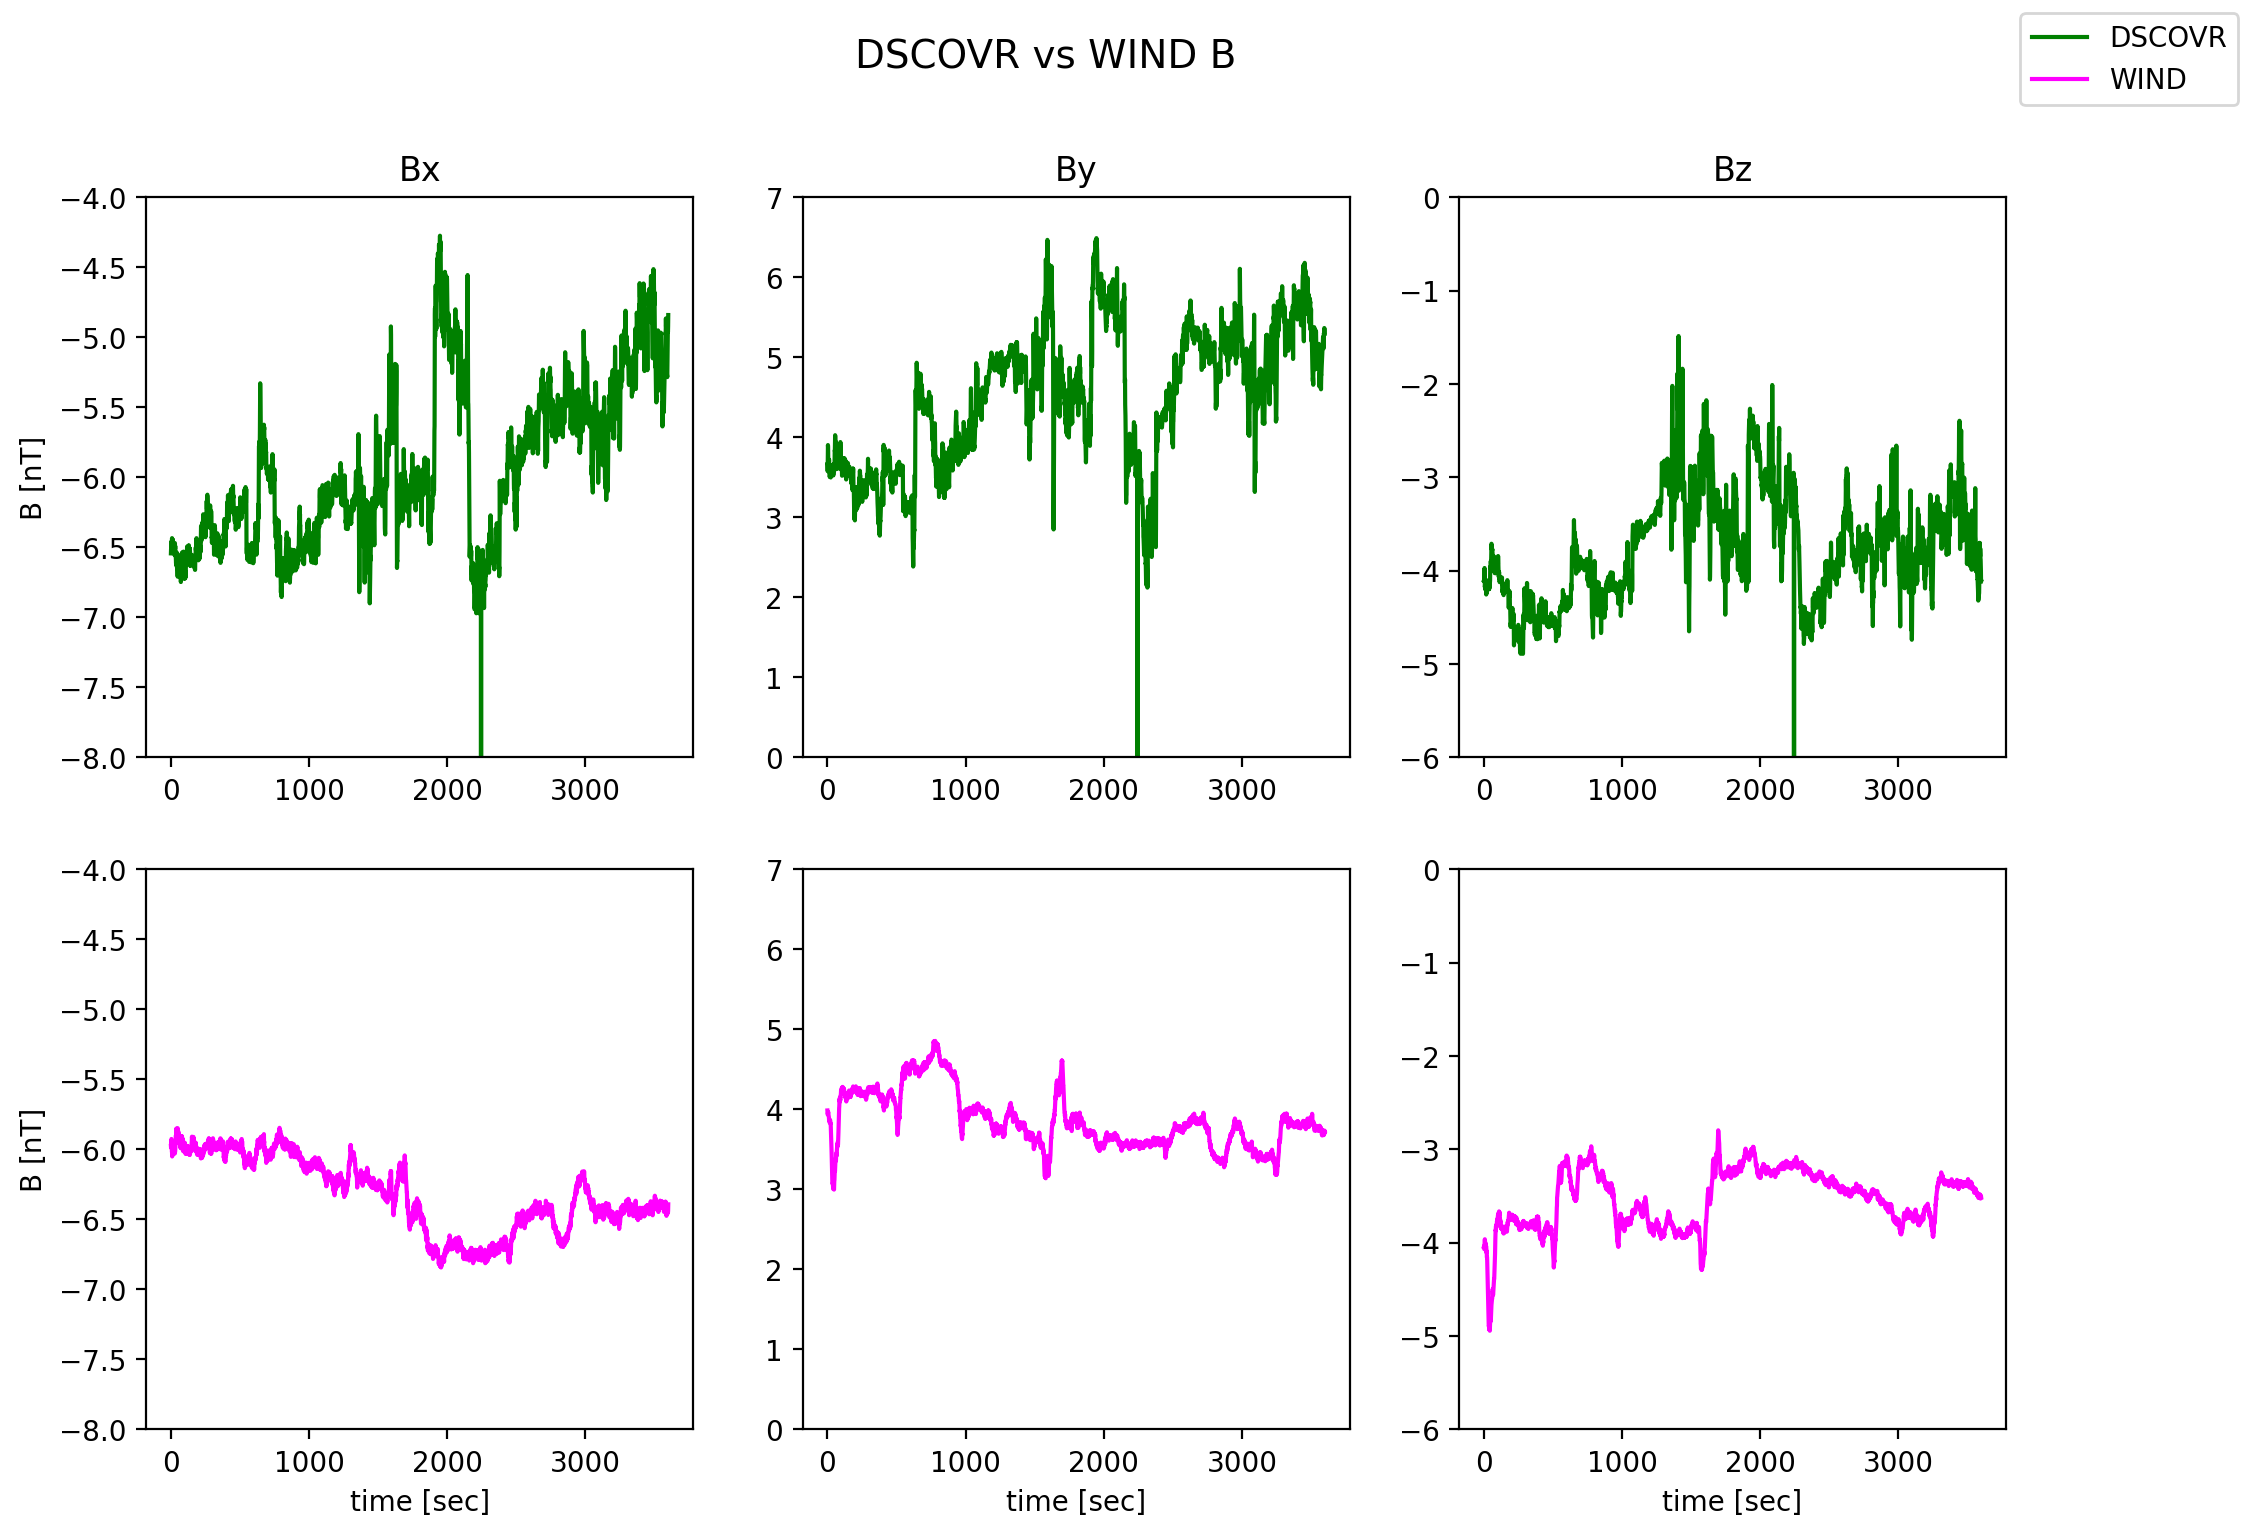

In [ ]:
fig, axs = plt.subplots(2, 3)
title = 'DSCOVR vs WIND B'
fig.suptitle(title, fontsize=14)
start = 0
stop = 3600
time_axis = np.linspace(start, stop, num=stop-start, endpoint=False)

d_bx, = axs[0,0].plot(time_axis, dsc_B[start:stop,0], color=dsc_colour, label='Bx')
d_by, = axs[0,1].plot(time_axis, dsc_B[start:stop,1], color=dsc_colour, label='By')
d_bz, = axs[0,2].plot(time_axis, dsc_B[start:stop,2], color=dsc_colour, label='Bz')
axs[0, 0].set(title='Bx', ylabel='B [nT]')
axs[0, 1].set(title='By')
axs[0, 2].set(title='Bz')
axs[1, 0].set(xlabel='time [sec]', ylabel='B [nT]')
axs[1, 1].set(xlabel='time [sec]')
axs[1, 2].set(xlabel='time [sec]')
axs[0, 0].set(ylim=(-8,-4))
axs[0, 1].set(ylim=(0,7))
axs[0, 2].set(ylim=(-6,0))
axs[1, 0].set(ylim=(-8,-4))
axs[1, 1].set(ylim=(0,7))
axs[1, 2].set(ylim=(-6,0))

w_bx, = axs[1,0].plot(time_axis, wnd_B[start:stop,0], color=wnd_colour, label='Bx')
w_by, = axs[1,1].plot(time_axis, wnd_B[start:stop,1], color=wnd_colour, label='By')
w_bz, = axs[1,2].plot(time_axis, wnd_B[start:stop,2], color=wnd_colour, label='Bz')

fig.legend([d_bx, w_bx], ['DSCOVR', 'WIND'], loc='upper right')

Well that looks more like it!